## ECG Heartbeat Classification Datset
This notebook involves the making of machine learning models to classify the given data of obtained as an heartbeat ECG into differen classes. We'll undergo machine learning processes to classify them. AS given in the dataset,  we are given 5 different classes of heartbeat as [N:0, S:1, V:2 , F:3, Q:4]
* N: Non-Ectopic Beats
* S: Superventrical Ectopic Beats
* V: Ventricular Ectopic Beats
* F: Fusion Beats
* Q: Unknown Beats

The **CNN Algotithm** that we'll implement will classigy the given heartbeat into one of these classes

In [43]:
# importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, tqdm, re, time, itertools, sys
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
import matplotlib.pyplot as plt

In [44]:
import warnings
warnings.filterwarnings('ignore')

## Loading the Data
The first step is to load the data in our memory. We'll load all data provided to us in our notebook, and then start the machine learning process

In [45]:
# loading all data files into memory
start = time.time()

data_train = pd.read_csv('C:/Users/Usuario/Documents/Github/F2-CPU/database/mitbih_train.csv', header=None)
data_test = pd.read_csv('C:/Users/Usuario/Documents/Github/F2-CPU/database//mitbih_test.csv', header=None)
abnormal = pd.read_csv('C:/Users/Usuario/Documents/Github/F2-CPU/database//ptbdb_abnormal.csv', header=None)
normal = pd.read_csv('C:/Users/Usuario/Documents/Github/F2-CPU/database//ptbdb_normal.csv', header=None)

end = time.time()
print('Time taken: %.3f seconds' % (end-start))

print('Data loaded........')

Time taken: 6.006 seconds
Data loaded........


In [46]:
normal = normal.drop([187], axis=1)
abnormal = abnormal.drop([187], axis=1)

## EDA (Exploratory Data Analysis)
In this step, we will undergo an EDA (Exploratory Data Analysis) to get brief understanding of our data. We are given a data concerned with the ECG of a patient, classified into normal and abnormal classes. We'll make some plots to see the variations in the heart rate of a patient with normal and abnormal ECG.  

In [47]:
data_train.isnull().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [48]:
# checking the dataset shape
abnormal.shape, normal.shape

((10506, 187), (4046, 187))

We have a total of **10506** rows and **188** columns for abormal & **4045** rows and **188** columns of a normal ECG in our data

In [49]:
# view first 4 rows of data
data_train.head(4)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As it can be seen, the data is composed of columns (features) that contain the floating point numbers that represent the heart rate. 

In [50]:
# checking the columns
data_train.columns

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            178, 179, 180, 181, 182, 183, 184, 185, 186, 187],
           dtype='int64', length=188)

In [51]:
abnormal.shape, normal.shape

((10506, 187), (4046, 187))

In [52]:
# view first 2 rows of abnormal ECG data
abnormal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# view first 2 rows of normal data|
normal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,1.0,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
flatten_y = abnormal.values
flatten_y = flatten_y[:, 5:70].flatten()
flatten_y

array([0.93397045, 0.80104256, 0.7497828 , ..., 0.06976745, 0.06078224,
       0.06606765])

### Data Visualization
For better comprehension, we'll plot the data of normal and abnormal ECG rate to see how the curves look like. Given below are some plots of normal and abnormal ECG rate. 

### Abormal ECG Visualization
Below are some plots showing the ECG Curve of those persons who have an abnormal ECG rate

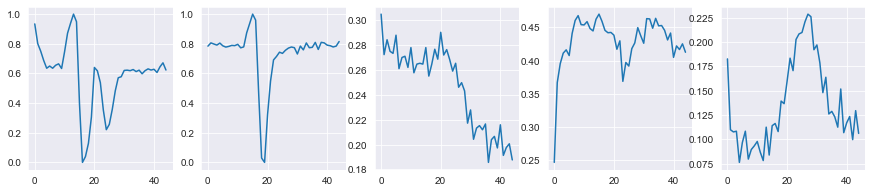

In [55]:
plt.figure(figsize=(15, 3))
plt.title('ECG Visualization of Abormal Persons')
plt.subplot(1, 5, 1)
plt.plot(abnormal.values[0][5:50])
plt.subplot(1, 5, 2)
plt.plot(abnormal.values[10][5:50])
plt.subplot(1, 5, 3)
plt.plot(abnormal.values[20][5:50])
plt.subplot(1, 5, 4)
plt.plot(abnormal.values[40][5:50])
plt.subplot(1, 5, 5)
plt.plot(abnormal.values[44][5:50])

## Normal ECG Visualization
Below are the graphs showing the ECG rate of normal persons

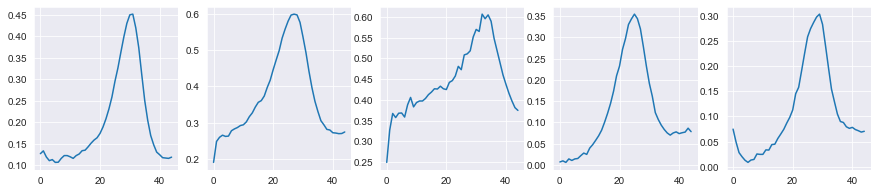

In [56]:
plt.figure(figsize=(15, 3))
plt.title('ECG Visualization of Normal Persons')
plt.subplot(1, 5, 1)
plt.plot(normal.values[0][5:50])
plt.subplot(1, 5, 2)
plt.plot(normal.values[10][5:50])
plt.subplot(1, 5, 3)
plt.plot(normal.values[20][5:50])
plt.subplot(1, 5, 4)
plt.plot(normal.values[40][5:50])
plt.subplot(1, 5, 5)
plt.plot(normal.values[77][5:50])

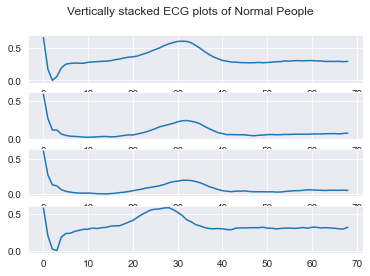

In [57]:
fig, axs = plt.subplots(4)
fig.suptitle('Vertically stacked ECG plots of Normal People')
axs[0].plot(normal.values[10][1:70])
axs[1].plot(normal.values[55][1:70])
axs[2].plot(normal.values[87][1:70])
axs[3].plot(normal.values[98][1:70])

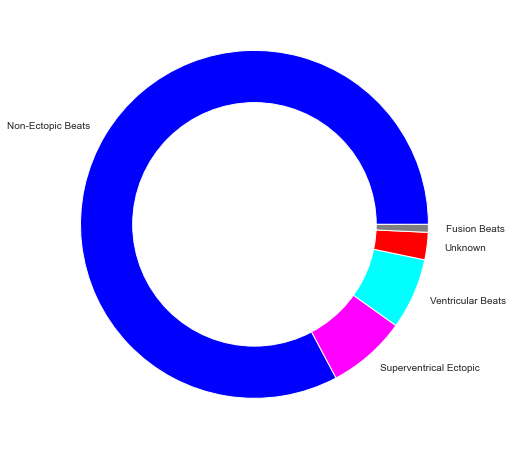

In [58]:
# viewing the distribution of beats in our dataset 
plt.figure(figsize=(10, 8))
circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(data_train[187].value_counts(), labels=['Non-Ectopic Beats', 'Superventrical Ectopic', 'Ventricular Beats',
                                                'Unknown', 'Fusion Beats'], colors=['blue', 'magenta', 'cyan', 
                                                                                   'red', 'grey'])
p = plt.gcf()
p.gca().add_artist(circle)

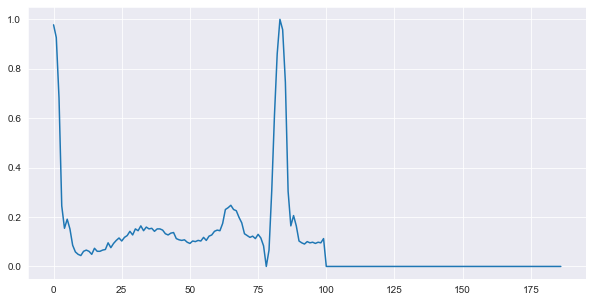

In [59]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 5))
plt.plot(data_train.iloc[0, 0:187])

## Conclusion:
We can conclude from above figures that the persons having normal ECG rate, the figures are following a **bell-curve** pattern. The ECG of abnormal persons show othe types of curves. We'll use this information to make our machine learning model for classification.

## Data Preprocessing
At this stage, we'll undergo some data preprocessing process to see if the data needs to be cleaned. Cleaned data is requried for model fitting in next phases. 

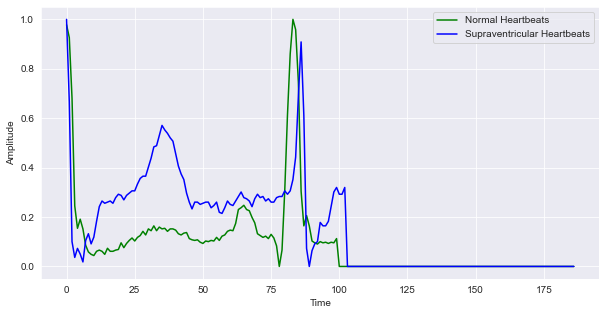

In [60]:
# making the class labels for our dataset
data_1 = data_train[data_train[187] == 1]
data_2 = data_train[data_train[187] == 2]
data_3 = data_train[data_train[187] == 3]
data_4 = data_train[data_train[187] == 4]

sns.set_style('darkgrid')
plt.figure(figsize=(10, 5))
plt.plot(data_train.iloc[0, 0:187], color='green', label='Normal Heartbeats')
plt.plot(data_1.iloc[0, 0:187], color='blue', label='Supraventricular Heartbeats')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

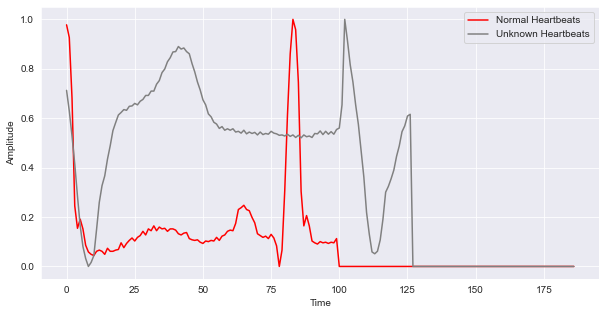

In [61]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 5))
plt.plot(data_train.iloc[0, 0:187], color='red', label='Normal Heartbeats')
plt.plot(data_4.iloc[0, 0:187], color='grey', label='Unknown Heartbeats')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

In [62]:
y_abnormal = np.ones(abnormal.shape[0])
y_abnormal = pd.DataFrame(y_abnormal)

y_normal = np.zeros(normal.shape[0])
y_normal = pd.DataFrame(y_normal)

# merging the original dataframe
X = pd.concat([abnormal, normal], sort=True)
y = pd.concat([y_abnormal, y_normal], sort=True)

In [63]:
print(X.shape)
print(y.shape)

(14552, 187)
(14552, 1)


In [64]:
# checking if there are some null values in data
normal.isnull().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [65]:
# checking if there are some null values in abnormal patient data
abnormal.isnull().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

The output of above cell shows that there are no null values in our data, and the data can now be used for model fitting. We have two types of datasets, normal and abnormal, and they'll be used for model fitting.  

## Data Argumentation
Since our data in biased, we need to use data argumentation on it so that we can remove bias from data and make equal distributions.

In [66]:
from sklearn.utils import resample
data_1_resample = resample(data_1, n_samples=20000, 
                           random_state=123, replace=True)
data_2_resample = resample(data_2, n_samples=20000, 
                           random_state=123, replace=True)
data_3_resample = resample(data_3, n_samples=20000, 
                           random_state=123, replace=True)
data_4_resample = resample(data_4, n_samples=20000, 
                           random_state=123, replace=True)
data_0 = data_train[data_train[187] == 0].sample(n=20000, random_state=123)

In [42]:
train_dataset = pd.concat([data_0, data_1_resample, data_2_resample, data_3_resample, 
                          data_4_resample]) # type: ignore # type: ignore

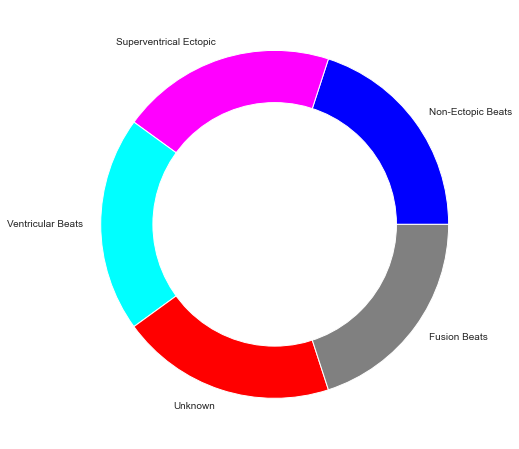

In [26]:
# viewing the distribution of beats in our dataset 
plt.figure(figsize=(10, 8))
circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(train_dataset[187].value_counts(), labels=['Non-Ectopic Beats', 'Superventrical Ectopic', 'Ventricular Beats',
                                                'Unknown', 'Fusion Beats'], colors=['blue', 'magenta', 'cyan', 
                                                                                   'red', 'grey'])
p = plt.gcf()
p.gca().add_artist(circle)

## Making X & Y Variables

In [27]:
target_train = train_dataset[187]
target_test = data_test[187]
target_train.unique()

array([0., 1., 2., 3., 4.])

In [28]:
y_train = to_categorical(target_train)
y_test = to_categorical(target_test)
y_train[:4]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

## Data Splicing
This stage involves the data split into train & test sets. The training data will be used for training our model, and the testing data will be used to check the performance of model on unseen dataset. We're using a split of **80-20**, i.e., **80%** data to be used for training & **20%** to be used for testing purpose.  

In [29]:
# making train & test splits
X_train = train_dataset.iloc[:, :-1].values
X_test = data_test.iloc[:, :-1].values

In [30]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100000, 187)
(21892, 187)
(100000, 5)
(21892, 5)


## Applying the Model
We are making use of following models to make our classification:
* Random Forest Classification
* Support Vector Machines (SVM)
* Convolutional Neural Network (CNN)

Steps:
* We will instantiate the model
* After intantiation, the model will be fit to training data
* After then, the model will be tested on useen data to make predictions

## Convolutional Neural Network (CNN)
We will apply the CNN algorithm to our data to generate prediction results.
First, we need to reshape our data for CNN. We will use 1-dimensional CNN for our model, reshaping our data as per the dimensins of our CNN>  

In [31]:
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)
X_train.shape, X_test.shape

((100000, 187, 1), (21892, 187, 1))

In [32]:
# making the deep learning function
def model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(187, 1)))
    model.add(BatchNormalization())
    
    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(187, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(187, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [33]:
model = model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 187, 64)           448       
                                                                 
 batch_normalization (BatchN  (None, 187, 64)          256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 94, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 94, 64)            24640     
                                                                 
 batch_normalization_1 (Batc  (None, 94, 64)           256       
 hNormalization)                                                 
                                                        

In [34]:
logger = CSVLogger('logs.csv', append=True)
his = model.fit(X_train, y_train, epochs=50, batch_size=32, 
          validation_data=(X_test, y_test), callbacks=[logger])

Epoch 1/50
3125/3125 [==============================] - 69s 19ms/step - loss: 0.1822 - accuracy: 0.9349 - val_loss: 0.1729 - val_accuracy: 0.9376
Epoch 2/50
3125/3125 [==============================] - 49s 16ms/step - loss: 0.0750 - accuracy: 0.9744 - val_loss: 0.1814 - val_accuracy: 0.9396
Epoch 3/50
3125/3125 [==============================] - 48s 15ms/step - loss: 0.0502 - accuracy: 0.9829 - val_loss: 0.2238 - val_accuracy: 0.9263
Epoch 4/50
3125/3125 [==============================] - 63s 20ms/step - loss: 0.0374 - accuracy: 0.9881 - val_loss: 0.1495 - val_accuracy: 0.9613
Epoch 5/50
3125/3125 [==============================] - 61s 19ms/step - loss: 0.0313 - accuracy: 0.9903 - val_loss: 0.1155 - val_accuracy: 0.9730
Epoch 6/50
3125/3125 [==============================] - 57s 18ms/step - loss: 0.0273 - accuracy: 0.9919 - val_loss: 0.1289 - val_accuracy: 0.9727
Epoch 7/50
3125/3125 [==============================] - 51s 16ms/step - loss: 0.0227 - accuracy: 0.9933 - val_loss: 0.1022 -

In [35]:
model.evaluate(X_test, y_test)

685/685 [==============================] - 6s 9ms/step - loss: 0.2077 - accuracy: 0.9802


[0.20765070617198944, 0.9801754355430603]

## Graphical Visualization of Predictions

In [36]:
history = his.history
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

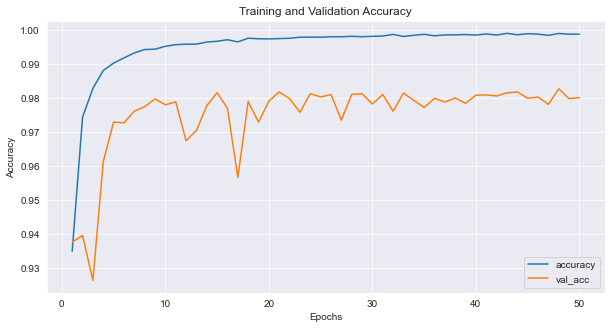

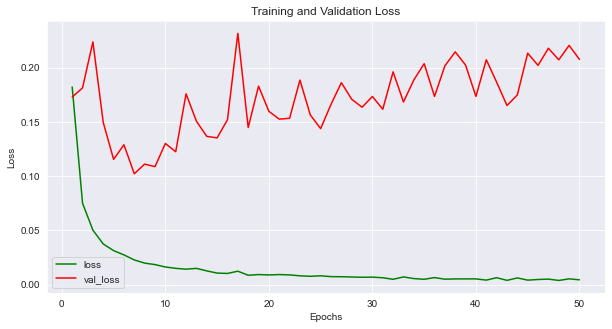

In [37]:
epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()

In [38]:
y_pred = model.predict(X_test)
y_hat = np.argmax(y_pred, axis = 1)
confusion_matrix(np.argmax(y_test, axis = 1), y_hat)

685/685 [==============================] - 4s 5ms/step


array([[17838,   162,    50,    47,    21],
       [   59,   488,     8,     1,     0],
       [   19,     6,  1402,    17,     4],
       [    9,     1,    15,   136,     1],
       [    9,     0,     5,     0,  1594]], dtype=int64)

<AxesSubplot:>

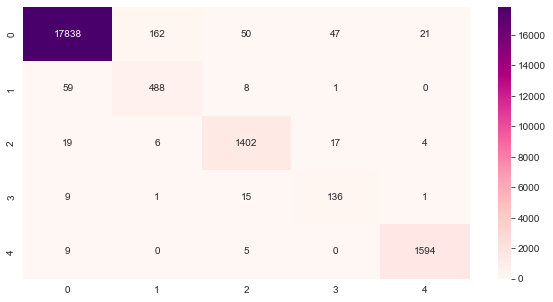

In [39]:
plt.figure(figsize=(10, 5))
sns.heatmap(confusion_matrix(np.argmax(y_test, axis = 1), y_hat), annot=True, fmt='0.0f', cmap='RdPu')

### 1. Random Forest Classifier
In this section, we use Random Forest Classifier to fit to our training dataset & predict results. 

In [70]:
# instantiate the classifier and fit to training data
start = time.time()
#X_train = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
#y_train = y_train.reshape(y_train.shape[0],y_train.shape[1]*y_train.shape[2])
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

Time Taken: 116.801 seconds


The model has been successfully fit to our training data. Let's check its performance on test set. 

In [ ]:
# viewing params of random forest
rf.get_params()

In [ ]:
# making predictions on test set
start = time.time()

y_pred = rf.predict(X_test)

end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

y_pred[:10]

In [ ]:
# check accuracy
print('Accuracy on train data: %.4f' % rf.score(X_train, y_train))
print('Accuracy on test data %.4f' % rf.score(X_test, y_test))

### 2. Support Vector Machine (SVM)
In this section, we'll fit SVM on our training dataset and check its performance on test data. 

In [ ]:
# instantiate ^ fit SVM to train data
svc = SVC()
svc.fit(X_train, y_train)

Model has been successfully fit to train data

In [ ]:
# check parameters of SVM
svc.get_params()

In [ ]:
# predict on test set
y_pred_svc = svc.predict(X_test)
y_pred_svc[:5]

In [ ]:
# check accuracy of SVM
print('Acc train %.4f' % svc.score(X_train, y_train))
print('Acc test %.4f' % svc.score(X_test, y_test))

As given, we are getting **92%** accuracy on training & **90%** accuracy on test dataset using **Support Vector Machines (SVM)**.  

## Prediction Results
In this section, we'll visualize the results obtained by **SVM** & **Random Forest**. The results are:
* Random Forest got an accuracy of **99%** on training data and **97%** on test data
* SVM got an accuracy of **92%** on train data and **90%** on test data
* We'll also plot confusion matrices of respective classifiers

In [ ]:
acc_rf = rf.score(X_test, y_test)
acc_svm = rf.score(X_test, y_test)
classifiers = ['Random Forest', 'SVM']
plt.title('Accuracy of SVM & Random Forest on Test Data')
plt.ylabel('Accuracy')
plt.bar(classifiers, [acc_rf, acc_svm])

In [ ]:
# print classification report of SVM anf RF
print('Classification Report of Random Forest:')
print('')
print(classification_report(y_test, y_pred))

In [ ]:
# print classification report of SVM anf RF
print('Classification Report of SVM:')
print('')
print(classification_report(y_test, y_pred_svc))

## Confusion Matrices
Below are the confusion matrices obtained as a result of classification from Random Forest & SVM:

### Confuion Matrix for Random Forest

In [ ]:
# confusion matrix for Random Forest
plot_confusion_matrix(rf, X_test, y_test)

### Confuion Matrix for SVM

In [ ]:
# confusion matrix for Random Forest
plot_confusion_matrix(svc, X_test, y_test)